In [1]:
import application
import audiostream
import audiolib
import config
import models
import charts

import time
import numpy as np

Using TensorFlow backend.


In [2]:
application.init()
model = application.load_model()

Resuming at batch 42548
Loading model from checkpoints\voice-embeddings.h5
Preloaded model from checkpoints\voice-embeddings.h5


In [4]:
model.optimizer.lr.get_value()

AttributeError: 'RefVariable' object has no attribute 'get_value'

In [2]:
clip1 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [213]:
def sound_chunks(sound, chunk_seconds=1.6, step_seconds=0.5, sample_rate=44100):
    """Return a sequence of sound chunks from a sound clip.
    Each chunk will be 1.6 seconds of the sound, and each
    successive chunk will be advanced by the specified number of seconds.
    sound: a numpy array of 16-bit signed integers representing a sound sample.
    """
    chunk_len = int(chunk_seconds * sample_rate)
    chunk_step = int(step_seconds * sample_rate)
    chunk_count = int(len(sound) / chunk_step)
    for i in range(chunk_count):
        start = i * chunk_step
        end = start + chunk_len
        yield sound[start:end]

def embeddings_from_sound(model, sound, sample_rate=16000):
    """Return a sequence of embeddings from the different time slices
    in the sound clip.
    sound: a numpy array of 16-bit signed integers representing a sound sample.
    """
    # The 1.601 is a hack to make sure we end up with a shape of 160 instead of 159.
    # What we actually want is 1.6.
    #*TODO: Figure out a better way to fix the 159->160 off by one error than adding .001.
    chunk_seconds=1.61
    for chunk in sound_chunks(sound, chunk_seconds=chunk_seconds, sample_rate=sample_rate):
        # The last portion of the sound may be less than our desired length.
        # We can safely skip it because we'll process it later as it shifts down the time window.
        lc = len(chunk)
        #print('lc=%d sec=%f delta=%f' % (lc, lc/sample_rate, lc/sample_rate - chunk_seconds))
        if len(chunk)/sample_rate - chunk_seconds < -0.009:
            continue
        yield calc_embedding(model, chunk)

def calc_embedding(model, sound, sample_rate=16000):
    """
    sound: a numpy array of 16-bit signed sound samples.
    """
    features = audiolib.extract_features(sound, sample_rate=sample_rate, num_filters=config.NUM_FILTERS)
    if len(features) < 160:
        raise Exception('need exactly 160 features to calculate an embedding, but got %d' % len(features))
    emb = models.get_embedding(model, features)
    return emb

def compare_embeddings(emb1, emb2):
    """Returns a scalar indicating the difference between 2 embeddings.
    Smaller numbers indicate closer.
    """
    dist = np.linalg.norm(emb1 - emb2)
    return dist

In [7]:
len(clip1), len(clip1)/16000

(64000, 4.0)

In [65]:
import itertools

def compare_embedding_permutations(embeddings):
    """Compare multiple embeddings against each other.
    Given a list of multiple embeddings, compare all the combinations of them taken 2 at a time.
    Returns a list of scalars representing the various comparisons.
    """
    for emb1, emb2 in itertools.permutations(embeddings, 2):
        yield compare_embeddings(emb1, emb2)

In [69]:
rico1_embs = list(embeddings_from_sound(model, clip1, sample_rate=16000))

In [70]:
rico1_comparisons = list(compare_embedding_permutations(rico1_embs))

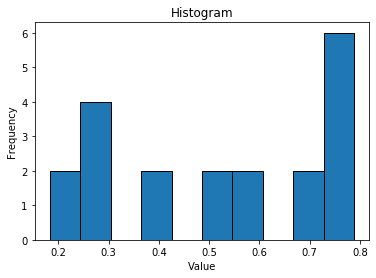

In [71]:
charts.histogram(rico1_comparisons)

In [64]:
compare_embeddings(rico1_embs[0], emb1[0])

0.40245754

In [72]:
rico_clip2 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [74]:
rico2_embs = list(embeddings_from_sound(model, rico_clip2, sample_rate=16000))

In [77]:
rico2_comparisons = list(compare_embedding_permutations(rico2_embs))

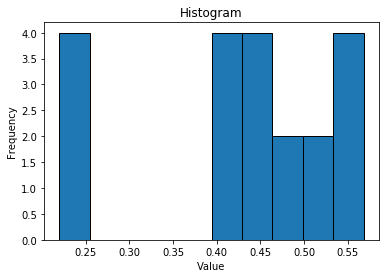

In [78]:
charts.histogram(rico2_comparisons)

In [85]:
compare_embeddings(rico1_embs[3], rico2_embs[3])

0.60666585

In [88]:
cor_clip1 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [89]:
cor_clip2 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [90]:
cor_clip3 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [135]:
cor1_embs = list(embeddings_from_sound(model, cor_clip1, sample_rate=16000))
cor2_embs = list(embeddings_from_sound(model, cor_clip1, sample_rate=16000))
cor3_embs = list(embeddings_from_sound(model, cor_clip1, sample_rate=16000))

In [99]:
compare_embeddings(rico1_embs[2], cor1_embs[3])

1.5730244

In [100]:
jecka_clip1 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [101]:
jecka_clip2 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [102]:
jecka_clip3 = audiostream.record(4, rate=16000)

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording finished


In [103]:
audiolib.save_wav(r'd:\tmp\rico1.wav', clip1, rate=16000)
audiolib.save_wav(r'd:\tmp\rico2.wav', rico_clip2, rate=16000)
audiolib.save_wav(r'd:\tmp\cor_clip1.wav', cor_clip1, rate=16000)
audiolib.save_wav(r'd:\tmp\cor_clip2.wav', cor_clip2, rate=16000)
audiolib.save_wav(r'd:\tmp\cor_clip3.wav', cor_clip3, rate=16000)
audiolib.save_wav(r'd:\tmp\jecka_clip1.wav', jecka_clip1, rate=16000)
audiolib.save_wav(r'd:\tmp\jecka_clip2.wav', jecka_clip2, rate=16000)
audiolib.save_wav(r'd:\tmp\jecka_clip3.wav', jecka_clip3, rate=16000)

In [110]:
jecka1_embs = list(embeddings_from_sound(model, jecka_clip1, sample_rate=16000))
jecka2_embs = list(embeddings_from_sound(model, jecka_clip2, sample_rate=16000))
jecka3_embs = list(embeddings_from_sound(model, jecka_clip3, sample_rate=16000))

In [124]:
compare_embeddings(jecka1_embs[0],rico1_embs[0])

1.2861824

In [125]:
compare_embeddings(jecka1_embs[1],jecka2_embs[0])

0.8714248

In [126]:
compare_embeddings(cor1_embs[1],jecka2_embs[0])

1.1345081

In [155]:
class KnownSpeaker:
    def __init__(self, name):
        self.name = name
        self.embeddings = [] # A list of embeddings of known utterances by this speaker.
    
    def add_embeddings(self, embeddings):
        self.embeddings.extend(embeddings)
    
    def distance(self, anchor_embedding):
        """Returns the average distance of the embedding to known
        utterances by this speaker.
        """
        distances = [compare_embeddings(anchor_embedding, emb) for emb in self.embeddings]
        return np.mean(distances)

In [157]:
rico = KnownSpeaker('Rico')
rico.add_embeddings(rico1_embs)
rico.add_embeddings(rico2_embs)
cor = KnownSpeaker('Cor')
cor.add_embeddings(cor1_embs)
cor.add_embeddings(cor2_embs)
cor.add_embeddings(cor3_embs)
jecka = KnownSpeaker('Jecka')
jecka.add_embeddings(jecka1_embs)
jecka.add_embeddings(jecka2_embs)
jecka.add_embeddings(jecka2_embs)

In [169]:
emb = rico2_embs[3]
#emb = cor1_embs[3]
#emb = jecka2_embs[3]
rico.distance(emb), cor.distance(emb), jecka.distance(emb)

(0.49930662, 1.5563623, 1.2464644)

In [231]:
class RecognizerPrototype:
    def __init__(self, known_speakers, model):
        self.known_speakers = known_speakers
        self.model = model
    
    def run(self, duration_seconds=20):
        rate = 16000
        stream = audiostream.AudioStream(seconds=4, rate=rate)
        stream.start()
        seconds_remaining = duration_seconds
        speaker_name = '-'
        speaker = None
        step_duration = 0.5
        dist = 999
        while seconds_remaining > 0:
            print('%d remaining. dist=%f Speaker=%s' % (seconds_remaining, dist, speaker_name))
            time.sleep(step_duration)
            
            sound = stream.sound_array()
            if len(sound)/rate < 1.61:
                continue
            embs = list(embeddings_from_sound(self.model, sound, sample_rate=rate))
            # To avoid the rounding error of 159 frames instead of 160, we need at least 2 full chunks.
            if len(embs) <1:
                continue
            # Later, we could change this to use multiple embeddings form the last few seconds.
            # For now we'll just get the last full chunk.
            embedding = embs[-1]
            dist, speaker = self.determine_speaker(embedding)
            if dist < 0.99:
                speaker_name = speaker.name
            else:
                speaker_name = '-'
            
            seconds_remaining -= step_duration
    
    def determine_speaker(self, embedding):
        best_speaker = None
        best_dist = 999
        for speaker in self.known_speakers:
            dist = speaker.distance(embedding)
            if dist < best_dist:
                best_dist = dist
                best_speaker = speaker
        return best_dist, best_speaker

In [235]:
r = RecognizerPrototype([rico, cor, jecka], model)
r.run(duration_seconds=15)

15 remaining. dist=999.000000 Speaker=-
15 remaining. dist=999.000000 Speaker=-
15 remaining. dist=999.000000 Speaker=-
15 remaining. dist=999.000000 Speaker=-
14 remaining. dist=1.161672 Speaker=-
14 remaining. dist=0.963942 Speaker=Cor
13 remaining. dist=0.787207 Speaker=Cor
13 remaining. dist=0.941732 Speaker=Cor
12 remaining. dist=0.850635 Speaker=Cor
12 remaining. dist=0.895779 Speaker=Cor
11 remaining. dist=1.052427 Speaker=-
11 remaining. dist=0.857238 Speaker=Cor
10 remaining. dist=1.042673 Speaker=-
10 remaining. dist=1.156600 Speaker=-
9 remaining. dist=1.305294 Speaker=-
9 remaining. dist=1.246918 Speaker=-
8 remaining. dist=1.161736 Speaker=-
8 remaining. dist=0.900886 Speaker=Rico
7 remaining. dist=1.151994 Speaker=-
7 remaining. dist=0.781099 Speaker=Rico
6 remaining. dist=0.743346 Speaker=Rico
6 remaining. dist=1.173527 Speaker=-
5 remaining. dist=1.402816 Speaker=-
5 remaining. dist=1.385853 Speaker=-
4 remaining. dist=1.395822 Speaker=-
4 remaining. dist=1.351745 Speak